# Analisi database e-commerce - ETL ed EDA con Python

## Import, configurazione e caricamento dataset

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

customers = pd.read_csv('customers.csv')
order_items = pd.read_csv('order_items.csv')
orders = pd.read_csv('orders.csv')
payments = pd.read_csv('payments.csv')
products = pd.read_csv('products.csv')
returns = pd.read_csv('returns.csv')

In questa prima cella abbiamo importato tutte le librerie necessarie per il nostro progetto di analisi. **Pandas** ci serve per manipolare i dati in formato tabellare, **NumPy** per i calcoli numerici, **Matplotlib** per creare delle visualizzazioni, che però in questo notebook utilizzeremo solo una volta.

Abbiamo anche importato stats da **scipy** per la detection degli outlier tramite z-score, e da **scikit-learn** abbiamo preso KMeans per il clustering e StandardScaler per normalizzare i dati prima di applicare l'algoritmo di machine learning.

Subito dopo abbiamo caricato i sei dataset CSV che compongono il nostro database aziendale. `customers` contiene le informazioni anagrafiche dei clienti con la loro regione di appartenenza, `orders` raccoglie tutti gli ordini con data e stato, `order_items` dettaglia i singoli articoli di ogni ordine con quantità e prezzo, `products` è il catalogo prodotti con categorie e prezzi, `payments` registra i pagamenti effettuati, e returns tiene traccia dei resi con le relative motivazioni.

Questi sei file rappresentano le tabelle del nostro sistema e-commerce e li abbiamo tenuti separati per poterli poi unire tramite join in base alle nostre esigenze di analisi.


## Controllo valori mancanti

In [ ]:
print("Data quality issues & assumptions")
print("-" * 80)

print("\nDUPLICATI:")
print(f"Customers: {customers.duplicated().sum()}")
print(f"Orders: {orders.duplicated().sum()}")
print(f"Order Items: {order_items.duplicated().sum()}")
print(f"Products: {products.duplicated().sum()}")
print(f"Payments: {payments.duplicated().sum()}")
print(f"Returns: {returns.duplicated().sum()}")

print("\nVALORI MANCANTI:")
print(f"Customers: {customers.isnull().sum().sum()}")
print(f"Orders: {orders.isnull().sum().sum()}")
print(f"Order Items: {order_items.isnull().sum().sum()}")
print(f"Products: {products.isnull().sum().sum()}")
print(f"Payments: {payments.isnull().sum().sum()}")
print(f"Returns: {returns.isnull().sum().sum()}")

print("\nINTEGRITÀ:")
print(f"Customer IDs in orders non in customers: {len(set(orders['customer_id']) - set(customers['customer_id']))}")
print(f"Order IDs in order_items non in orders: {len(set(order_items['order_id']) - set(orders['order_id']))}")
print(f"Product IDs in order_items non in products: {len(set(order_items['product_id']) - set(products['product_id']))}")
print(f"Order IDs in payments non in orders: {len(set(payments['order_id']) - set(orders['order_id']))}")
print(f"Order IDs in returns non in orders: {len(set(returns['order_id']) - set(orders['order_id']))}")

Data quality issues & assumptions
--------------------------------------------------------------------------------

DUPLICATI:
Customers: 0
Orders: 0
Order Items: 7
Products: 0
Payments: 0
Returns: 0

VALORI MANCANTI:
Customers: 0
Orders: 0
Order Items: 0
Products: 0
Payments: 0
Returns: 0

INTEGRITÀ:
Customer IDs in orders non in customers: 0
Order IDs in order_items non in orders: 0
Product IDs in order_items non in products: 0
Order IDs in payments non in orders: 0
Order IDs in returns non in orders: 0


In [ ]:
order_items = order_items.drop_duplicates()

Prima di iniziare qualsiasi analisi abbiamo fatto un controllo di qualità sui dati. Questa sezione documenta i problemi riscontrati e le assunzioni che abbiamo dovuto fare. Abbiamo verificato tre aspetti: la presenza di righe duplicate, i valori mancanti e l'integrità referenziale tra le tabelle.

Per i duplicati abbiamo usato il metodo `duplicated()` su ogni dataframe, che restituisce *True* per le righe che sono copie esatte di altre già presenti. Per i valori mancanti abbiamo combinato `isnull()` con `sum()` due volte: la prima somma conta i null per colonna, la seconda somma tutto per avere un totale.

Nello specifico, per quanto riguarda la parte sull'integrità referenziale, abbiamo verificato che ogni chiave esterna punti effettivamente a un record esistente. Per esempio, abbiamo controllato che tutti i `customer_id` presenti negli ordini esistano anche nella tabella customers. Lo abbiamo fatto usando la differenza tra insiemi: `set(orders['customer_id']) - set(customers['customer_id'])` restituisce i `customer_id` che sono negli ordini ma non nei clienti. Se il risultato è zero, significa che tutti i riferimenti sono validi.

## Normalizzazione formati

In [ ]:
customers['signup_date'] = pd.to_datetime(customers['signup_date'])
orders['order_date'] = pd.to_datetime(orders['order_date'])

print("Date corrette")
print(customers['signup_date'].dtype)
print(orders['order_date'].dtype)

Date corrette
datetime64[ns]
datetime64[ns]


Le date nei file CSV vengono lette come stringhe di testo, quindi abbiamo dovuto convertirle in formato datetime usando `pd.to_datetime()`. Questo passaggio è essenziale perché ci permette di estrarre anno, mese e giorno, calcolare differenze temporali e ordinare cronologicamente.

Abbiamo convertito sia la data di registrazione dei clienti che la data degli ordini, verificando poi con `dtype` che il tipo sia effettivamente `datetime64`.

## Join e unificazione database

In [ ]:
df = order_items.merge(orders, on='order_id', how='left')
df = df.merge(customers, on='customer_id', how='left')
df = df.merge(products, on='product_id', how='left')
df = df.merge(payments, on='order_id', how='left')

print(f"Dataset unificato: {df.shape}")
display(df.head())

Dataset unificato: (499, 16)


,order_id,product_id,quantity,unit_price,customer_id,order_date,status,customer_name,region,signup_date,product_name,category,price,payment_id,payment_method,amount
0,1,11,4,88.39,8,2023-12-16,returned,Customer_8,Nord,2023-02-10,Product_11,Sport,88.39,1,Bonifico,1057.31
1,1,9,4,431.94,8,2023-12-16,returned,Customer_8,Nord,2023-02-10,Product_9,Elettronica,431.94,1,Bonifico,1057.31
2,1,9,1,431.94,8,2023-12-16,returned,Customer_8,Nord,2023-02-10,Product_9,Elettronica,431.94,1,Bonifico,1057.31
3,2,1,5,376.04,49,2023-05-17,returned,Customer_49,Centro,2023-11-24,Product_1,Casa,376.04,2,Carta,606.90
4,2,2,3,219.93,49,2023-05-17,returned,Customer_49,Centro,2023-11-24,Product_2,Sport,219.93,2,Carta,606.90


Abbiamo unito tutte le tabelle in un unico dataframe consolidato partendo da `order_items`, che rappresenta il livello di dettaglio più granulare dei nostri dati. Abbiamo fatto una serie di *left join*: prima con `orders` per aggiungere data e stato dell'ordine, poi con `customers` per avere nome e regione del cliente, poi con `products` per categoria e nome prodotto, infine con `payments` per il metodo e importo di pagamento.

Il risultato è un dataset di 499 righe e 16 colonne che contiene tutte le informazioni necessarie per le analisi successive.

Non abbiamo incluso `returns` in questo join perché non tutti gli ordini hanno un reso associato.

## Calcolo colonna derivata

In [ ]:
df['valore_totale'] = df['quantity'] * df['unit_price']
display(df[['order_id', 'product_id', 'quantity', 'unit_price', 'valore_totale']].head())

,order_id,product_id,quantity,unit_price,valore_totale
0,1,11,4,88.39,353.56
1,1,9,4,431.94,1727.76
2,1,9,1,431.94,431.94
3,2,1,5,376.04,1880.20
4,2,2,3,219.93,659.79


Abbiamo creato la prima colonna derivata moltiplicando la quantità per il prezzo unitario.

Questa metrica rappresenta il ricavo generato da ogni singola riga d'ordine ed è la base per tutte le analisi di fatturato che faremo successivamente.

## Calcolo del costo totale

In [ ]:
df['costo_unitario'] = df['unit_price'] * 0.60
df['costo_totale'] = df['costo_unitario'] * df['quantity']
display(df[['product_id', 'unit_price', 'costo_unitario', 'quantity', 'costo_totale']].head())

,product_id,unit_price,costo_unitario,quantity,costo_totale
0,11,88.39,53.034,4,212.136
1,9,431.94,259.164,4,1036.656
2,9,431.94,259.164,1,259.164
3,1,376.04,225.624,5,1128.120
4,2,219.93,131.958,3,395.874


Per calcolare il costo abbiamo dovuto fare un'assunzione importante: non avendo dati reali sui costi di acquisto dei prodotti, abbiamo ipotizzato un margine del 40%, quindi il costo è pari al 60% del prezzo di vendita.

Abbiamo quindi prima calcolato il costo unitario moltiplicando il prezzo per 0.60, poi il costo totale moltiplicando per la quantità.

Questa assunzione è documentata nella nostra analisi come parte delle "assumptions" del progetto.

## Calcolo margine in valore assoluto

In [ ]:
df['margine'] = df['valore_totale'] - df['costo_totale']
df['margine_percentuale'] = (df['margine'] / df['valore_totale']) * 100
display(df[['order_id', 'valore_totale', 'costo_totale', 'margine', 'margine_percentuale']].head())

,order_id,valore_totale,costo_totale,margine,margine_percentuale
0,1,353.56,212.136,141.424,40.0
1,1,1727.76,1036.656,691.104,40.0
2,1,431.94,259.164,172.776,40.0
3,2,1880.20,1128.120,752.080,40.0
4,2,659.79,395.874,263.916,40.0


Il margine è la differenza tra valore totale e costo totale, rappresenta il profitto lordo su ogni vendita. Abbiamo calcolato anche il margine percentuale dividendo il margine per il valore totale e moltiplicando per 100. Con la nostra assunzione del 60% di costo, il margine percentuale risulta essere costantemente del 40%.

## Calcolo del CLV (Customer Lifetime Value)

In [ ]:
clv = df.groupby('customer_id').agg({
    'valore_totale': 'sum',
    'order_id': 'nunique',
    'margine': 'sum'
}).rename(columns={
    'valore_totale': 'fatturato_cliente',
    'order_id': 'numero_ordini',
    'margine': 'margine_totale'
})

clv['valore_medio_ordine'] = clv['fatturato_cliente'] / clv['numero_ordini']
clv = clv.merge(customers[['customer_id', 'customer_name', 'region']], on='customer_id', how='left')

display(clv.head(10))

,customer_id,fatturato_cliente,numero_ordini,margine_totale,valore_medio_ordine,customer_name,region
0,1,7255.19,5,2902.076,1451.038000,Customer_1,Sud
1,2,12689.78,4,5075.912,3172.445000,Customer_2,Nord
2,3,3454.45,2,1381.780,1727.225000,Customer_3,Nord
3,4,13534.45,4,5413.780,3383.612500,Customer_4,Sud
4,5,4080.37,2,1632.148,2040.185000,Customer_5,Centro
5,6,12176.90,5,4870.760,2435.380000,Customer_6,Nord
6,7,3100.88,3,1240.352,1033.626667,Customer_7,Nord
7,8,5160.01,2,2064.004,2580.005000,Customer_8,Nord
8,9,12984.54,6,5193.816,2164.090000,Customer_9,Sud
9,10,3098.53,2,1239.412,1549.265000,Customer_10,Nord


Abbiamo calcolato il CLV raggruppando i dati per cliente e aggregando tre metriche: la somma del valore totale come fatturato cliente, il conteggio degli ordini unici come numero ordini e la somma del margine come margine totale.

Abbiamo poi calcolato il valore medio ordine dividendo il fatturato per il numero di ordini e, infine, abbiamo aggiunto nome e regione del cliente con un merge per rendere i dati più leggibili.

Il CLV ci dice quanto vale ogni cliente nel tempo ed è una metrica importantissima per le strategie di retention.

Abbiamo poi ordinato i clienti per fatturato decrescente e preso i primi 20 per identificare i clienti più preziosi.

I top 20 clienti generano il 60.80% del fatturato totale, confermando una forte concentrazione del valore. In media fanno 5.55 ordini con un valore medio di € 2,459.52.

La distribuzione geografica mostra una prevalenza del Nord con 9 clienti, seguito dal Sud con 7 e Centro con 4.


In [ ]:
top_clienti_clv = clv.sort_values('fatturato_cliente', ascending=False).head(20)

print("TOP 20 CLIENTI PER CUSTOMER LIFETIME VALUE")
print("-" * 80)
display(top_clienti_clv)

print("\nSTATISTICHE TOP 20 CLIENTI:")
print("-" * 80)
print(f"Fatturato totale Top 20: €{top_clienti_clv['fatturato_cliente'].sum():,.2f}")
print(f"% sul fatturato totale: {(top_clienti_clv['fatturato_cliente'].sum() / clv['fatturato_cliente'].sum() * 100):.2f}%")
print(f"Margine totale Top 20: €{top_clienti_clv['margine_totale'].sum():,.2f}")
print(f"Numero medio ordini: {top_clienti_clv['numero_ordini'].mean():.2f}")
print(f"Valore medio ordine: €{top_clienti_clv['valore_medio_ordine'].mean():,.2f}")

print("\nDISTRIBUZIONE GEOGRAFICA TOP 20:")
print("-" * 80)
print(top_clienti_clv['region'].value_counts())

TOP 20 CLIENTI PER CUSTOMER LIFETIME VALUE
--------------------------------------------------------------------------------


,customer_id,fatturato_cliente,numero_ordini,margine_totale,valore_medio_ordine,customer_name,region
21,22,25494.97,9,10197.988,2832.774444,Customer_22,Sud
42,43,20652.36,8,8260.944,2581.545000,Customer_43,Nord
20,21,15353.02,6,6141.208,2558.836667,Customer_21,Nord
12,13,14706.46,7,5882.584,2100.922857,Customer_13,Sud
13,14,14169.07,7,5667.628,2024.152857,Customer_14,Nord
3,4,13534.45,4,5413.780,3383.612500,Customer_4,Sud
47,48,13328.72,6,5331.488,2221.453333,Customer_48,Nord
39,40,13003.61,4,5201.444,3250.902500,Customer_40,Centro
8,9,12984.54,6,5193.816,2164.090000,Customer_9,Sud
15,16,12823.09,5,5129.236,2564.618000,Customer_16,Centro



STATISTICHE TOP 20 CLIENTI:
--------------------------------------------------------------------------------
Fatturato totale Top 20: €266,828.35
% sul fatturato totale: 60.80%
Margine totale Top 20: €106,731.34
Numero medio ordini: 5.55
Valore medio ordine: €2,459.52

DISTRIBUZIONE GEOGRAFICA TOP 20:
--------------------------------------------------------------------------------
region
Nord      9
Sud       7
Centro    4
Name: count, dtype: int64


## Segmentazione utenti

In [ ]:
clv['segmento'] = pd.qcut(clv['fatturato_cliente'],
                          q=4,
                          labels=['Bronzo', 'Argento', 'Oro', 'Platino'])

segmentazione = clv.groupby('segmento').agg({
    'customer_id': 'count',
    'fatturato_cliente': ['sum', 'mean'],
    'numero_ordini': 'mean',
    'margine_totale': 'sum',
    'valore_medio_ordine': 'mean'
}).round(2)

segmentazione.columns = ['Numero_clienti', 'Fatturato_fotale', 'Fatturato_medio',
                         'Ordini_medi', 'Margine_totale', 'Valore_medio_ordine']

print("SEGMENTAZIONE CLIENTI PER CLV (Quartili)")
print("-" * 80)
display(segmentazione)

print("\nDISTRIBUZIONE CLIENTI PER SEGMENTO:")
print(clv['segmento'].value_counts().sort_index())

SEGMENTAZIONE CLIENTI PER CLV (Quartili)
--------------------------------------------------------------------------------


/tmp/ipython-input-2715585678.py:5: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  segmentazione = clv.groupby('segmento').agg({


,Numero_clienti,Fatturato_fotale,Fatturato_medio,Ordini_medi,Margine_totale,Valore_medio_ordine
segmento,,,,,,
Bronzo,13,47996.07,3692.01,2.00,19198.43,1875.99
Argento,12,79376.48,6614.71,3.25,31750.59,2231.65
Oro,12,118663.49,9888.62,5.00,47465.40,2040.76
Platino,13,192839.56,14833.81,5.77,77135.82,2636.26



DISTRIBUZIONE CLIENTI PER SEGMENTO:
segmento
Bronzo     13
Argento    12
Oro        12
Platino    13
Name: count, dtype: int64


Abbiamo segmentato i clienti in quattro livelli usando `pd.qcut()` che divide in quartili di uguale numerosità: Bronzo, Argento, Oro e Platino.

Per ogni segmento abbiamo calcolato statistiche aggregate come numero clienti, fatturato totale e medio, ordini medi, margine totale e valore medio ordine.

La distribuzione risulta bilanciata con circa 12-13 clienti per segmento, come ci aspettavamo dai quartili.

## Tasso di reso

In [ ]:
totale_ordini = orders.shape[0]
ordini_resi = returns.shape[0]
tasso_reso = (ordini_resi / totale_ordini) * 100

print(f"Totale ordini: {totale_ordini}")
print(f"Ordini resi: {ordini_resi}")
print(f"Tasso di reso: {tasso_reso:.2f}%")

analisi_resi = order_items.merge(
    returns[['order_id']],
    on='order_id',
    how='left',
    indicator=True
)
analisi_resi['è_reso'] = analisi_resi['_merge'] == 'both'

resi_per_prodotto = analisi_resi.groupby('product_id').agg({
    'order_id': 'count',
    'è_reso': 'sum'
}).rename(columns={'order_id': 'totale_ordini', 'è_reso': 'ordini_resi'})

resi_per_prodotto['tasso_reso_%'] = (resi_per_prodotto['ordini_resi'] / resi_per_prodotto['totale_ordini']) * 100
resi_per_prodotto = resi_per_prodotto.merge(products[['product_id', 'product_name', 'category']], on='product_id')

display(resi_per_prodotto.sort_values('tasso_reso_%', ascending=False).head(10))

Totale ordini: 200
Ordini resi: 71
Tasso di reso: 35.50%


,product_id,totale_ordini,ordini_resi,tasso_reso_%,product_name,category
1,2,19,10,52.631579,Product_2,Sport
18,19,29,15,51.724138,Product_19,Casa
6,7,15,7,46.666667,Product_7,Beauty
3,4,24,11,45.833333,Product_4,Casa
2,3,48,21,43.750000,Product_3,Elettronica
0,1,19,8,42.105263,Product_1,Casa
11,12,31,13,41.935484,Product_12,Casa
15,16,24,10,41.666667,Product_16,Casa
8,9,25,10,40.000000,Product_9,Elettronica
13,14,24,9,37.500000,Product_14,Beauty


Successivamente, abbiamo calcolato il tasso di reso globale dividendo il numero di ordini resi per il totale degli ordini.

Il risultato è un tasso del 35.50%, piuttosto alto.

Abbiamo poi analizzato il tasso di reso per prodotto facendo un *left join* tra `order_items` e `returns` con l'opzione `indicator=True` che ci permette di identificare quali righe hanno trovato corrispondenza. Questo ci ha permesso di vedere quali prodotti hanno i tassi di reso più alti.

## Statistiche descrittive

In [ ]:
print("STATISTICHE DESCRITTIVE - Dataset principale")
colonne_analisi = ['quantity', 'unit_price', 'valore_totale', 'costo_totale',
                   'margine', 'margine_percentuale', 'amount']
display(df[colonne_analisi].describe().round(2))

print("\nSTATISTICHE DESCRITTIVE - CLV")
colonne_clv = ['fatturato_cliente', 'numero_ordini', 'margine_totale', 'valore_medio_ordine']
display(clv[colonne_clv].describe().round(2))

STATISTICHE DESCRITTIVE - Dataset principale


,quantity,unit_price,valore_totale,costo_totale,margine,margine_percentuale,amount
count,499.00,499.00,499.00,499.00,499.00,499.0,499.00
mean,3.08,283.14,879.51,527.71,351.80,40.0,618.90
std,1.39,122.31,582.66,349.60,233.07,0.0,325.08
min,1.00,77.78,77.78,46.67,31.11,40.0,29.65
25%,2.00,198.54,376.04,225.62,150.42,40.0,359.59
50%,3.00,295.93,755.46,453.28,302.18,40.0,612.15
75%,4.00,376.04,1295.82,777.49,518.33,40.0,891.65
max,5.00,498.69,2493.45,1496.07,997.38,40.0,1197.78



STATISTICHE DESCRITTIVE - CLV


,fatturato_cliente,numero_ordini,margine_totale,valore_medio_ordine
count,50.00,50.00,50.00,50.00
mean,8777.51,4.00,3511.00,2198.56
std,4748.53,1.84,1899.41,635.67
min,923.14,1.00,369.26,461.57
25%,5230.77,2.00,2092.31,1685.89
50%,7896.16,4.00,3158.46,2205.48
75%,11809.82,5.00,4723.93,2576.16
max,25494.97,9.00,10197.99,3718.10


In questa cella abbiamo usato `describe()` per ottenere le statistiche descrittive delle variabili numeriche più rilevanti: conteggio, media, deviazione standard, minimo, quartili e massimo.

Lo abbiamo fatto sia sul dataset principale selezionando le colonne di business come quantità, prezzi, valori e margini, sia sul dataframe CLV per vedere la distribuzione del valore dei clienti.

Abbiamo aggiunto `round(2)` per limitare i decimali e rendere i numeri più leggibili.

# Analisi delle vendite

### Per categoria

In [ ]:
vendite_categoria = df.groupby('category').agg({
    'valore_totale': 'sum',
    'quantity': 'sum',
    'order_id': 'nunique',
    'margine': 'sum'
}).round(2)

vendite_categoria.columns = ['Fatturato', 'Quantità', 'Numero_ordini', 'Margine']
vendite_categoria = vendite_categoria.sort_values('Fatturato', ascending=False)

display(vendite_categoria)

,Fatturato,Quantità,Numero_ordini,Margine
category,,,,
Casa,149373.06,532,124,59749.22
Elettronica,124557.14,325,84,49822.86
Sport,88964.74,399,107,35585.90
Beauty,75980.66,283,75,30392.26


Abbiamo aggregato le vendite per categoria prodotto calcolando fatturato totale, quantità venduta, numero di ordini unici e margine.

Ordinando per fatturato decrescente possiamo vedere quali categorie performano meglio e contribuiscono maggiormente al business.

### Per zona

In [ ]:
vendite_regione = df.groupby('region').agg({
    'valore_totale': 'sum',
    'quantity': 'sum',
    'order_id': 'nunique',
    'customer_id': 'nunique',
    'margine': 'sum'
}).round(2)

vendite_regione.columns = ['Fatturato', 'Quantità', 'Numero_ordini', 'Numero_clienti', 'Margine']
vendite_regione = vendite_regione.sort_values('Fatturato', ascending=False)

display(vendite_regione)

,Fatturato,Quantità,Numero_ordini,Numero_clienti,Margine
region,,,,,
Nord,186635.30,652,86,22,74654.12
Sud,154494.32,557,75,16,61797.73
Centro,97745.98,330,39,12,39098.39


Stessa logica applicata alla dimensione geografica: abbiamo raggruppato per regione e calcolato le stesse metriche più il numero di clienti unici.

Questo ci permette di confrontare le performance tra Nord, Centro e Sud e identificare eventuali opportunità di crescita territoriale.

### Per mese

In [ ]:
df['anno'] = df['order_date'].dt.year
df['mese'] = df['order_date'].dt.month
df['anno_mese'] = df['order_date'].dt.to_period('M')

performance_mensile = df.groupby('anno_mese').agg({
    'valore_totale': 'sum',
    'quantity': 'sum',
    'order_id': 'nunique',
    'margine': 'sum'
}).round(2)

performance_mensile.columns = ['Fatturato', 'Quantità', 'Numero_ordini', 'Margine']

display(performance_mensile)

,Fatturato,Quantità,Numero_ordini,Margine
anno_mese,,,,
2023-01,24337.97,73,13,9735.19
2023-02,46046.04,159,22,18418.42
2023-03,35399.10,116,16,14159.64
2023-04,26530.19,97,14,10612.08
2023-05,58029.46,183,21,23211.78
2023-06,42892.69,154,17,17157.08
2023-07,32128.89,117,16,12851.56
2023-08,32199.32,122,16,12879.73
2023-09,38206.64,135,17,15282.66


Abbiamo estratto anno, mese e creato una colonna `anno_mese` in formato Period dalla data dell'ordine.

Poi abbiamo raggruppato per mese e calcolato le metriche di performance.

Questa vista temporale ci permette di identificare trend, stagionalità e mesi di picco o calo.

## Tabelle pivot

### Per categoria e zona

In [ ]:
pivot_categoria_regione = pd.pivot_table(
    df,
    values='valore_totale',
    index='category',
    columns='region',
    aggfunc='sum',
    fill_value=0,
    margins=True,
    margins_name='Totale'
).round(2)

display(pivot_categoria_regione)

region,Centro,Nord,Sud,Totale
category,,,,
Beauty,17020.09,29108.77,29851.80,75980.66
Casa,32773.54,66372.85,50226.67,149373.06
Elettronica,31103.39,49030.63,44423.12,124557.14
Sport,16848.96,42123.05,29992.73,88964.74
Totale,97745.98,186635.30,154494.32,438875.60


Abbiamo creato una tabella pivot con le categorie sulle righe, le regioni sulle colonne e il fatturato nelle celle.

L'opzione `margins=True` aggiunge i totali di riga e colonna.

Questa vista incrociata mostra quale categoria vende meglio in quale regione, permettendo di identificare pattern geografici per linea di prodotto.

### Per categoria e mese

In [ ]:
pivot_mensile_categoria = pd.pivot_table(
    df,
    values='valore_totale',
    index='anno_mese',
    columns='category',
    aggfunc='sum',
    fill_value=0,
    margins=True,
    margins_name='Totale'
).round(2)

display(pivot_mensile_categoria)

category,Beauty,Casa,Elettronica,Sport,Totale
anno_mese,,,,,
2023-01,3212.08,7789.69,9769.64,3566.56,24337.97
2023-02,9250.24,14294.95,17758.68,4742.17,46046.04
2023-03,5436.32,10698.56,12179.92,7084.30,35399.10
2023-04,5769.87,11729.76,2359.95,6670.61,26530.19
2023-05,8500.25,21184.56,17880.78,10463.87,58029.46
2023-06,7750.52,10445.55,16777.72,7918.90,42892.69
2023-07,4114.66,14117.43,9782.15,4114.65,32128.89
2023-08,3306.42,14700.97,8769.75,5422.18,32199.32
2023-09,9063.92,11993.54,3162.06,13987.12,38206.64


Seconda tabella pivot con i mesi sulle righe e le categorie sulle colonne.

Mostra l'evoluzione temporale delle vendite per ogni categoria, utile per identificare stagionalità specifiche per tipo di prodotto.

### Per margine per categoria e regione

In [ ]:
pivot_margine_categoria_regione = pd.pivot_table(
    df,
    values='margine',
    index='category',
    columns='region',
    aggfunc='sum',
    fill_value=0,
    margins=True,
    margins_name='Totale'
).round(2)

display(pivot_margine_categoria_regione)

region,Centro,Nord,Sud,Totale
category,,,,
Beauty,6808.04,11643.51,11940.72,30392.26
Casa,13109.42,26549.14,20090.67,59749.22
Elettronica,12441.36,19612.25,17769.25,49822.86
Sport,6739.58,16849.22,11997.09,35585.90
Totale,39098.39,74654.12,61797.73,175550.24


Terza pivot table simile alla prima ma con il margine invece del fatturato.

Ci dice quali combinazioni categoria-regione sono più profittevoli, che non necessariamente coincidono con quelle a più alto fatturato.

## Identificazione outliers

### Z-score

In [ ]:
df['valore_totale_zscore'] = np.abs(stats.zscore(df['valore_totale']))
outliers_zscore = df[df['valore_totale_zscore'] > 2]

print(f"Outlier rilevati con Z-Score (>2): {len(outliers_zscore)}")
print("-" * 80)

display(outliers_zscore[['order_id', 'product_name', 'quantity', 'unit_price', 'valore_totale', 'valore_totale_zscore']].head(20))

Outlier rilevati con Z-Score (>2): 18
--------------------------------------------------------------------------------


,order_id,product_name,quantity,unit_price,valore_totale,valore_totale_zscore
28,12,Product_9,5,431.94,2159.70,2.199336
34,14,Product_19,5,471.79,2358.95,2.541643
59,24,Product_9,5,431.94,2159.70,2.199336
75,31,Product_5,5,498.69,2493.45,2.772710
103,42,Product_9,5,431.94,2159.70,2.199336
110,45,Product_9,5,431.94,2159.70,2.199336
160,64,Product_5,5,498.69,2493.45,2.772710
217,86,Product_9,5,431.94,2159.70,2.199336
268,112,Product_9,5,431.94,2159.70,2.199336
284,119,Product_19,5,471.79,2358.95,2.541643


Abbiamo applicato il primo metodo di detection outlier calcolando lo `z-score` del valore totale. Lo `z-score` misura quante deviazioni standard un valore si discosta dalla media.

Abbiamo preso il valore assoluto e filtrato quelli maggiori di 2, trovando 18 outlier. Questi rappresentano ordini con valori significativamente più alti della media, probabilmente ordini di grandi quantità di prodotti costosi.

### IQR

In [ ]:
Q1 = df['valore_totale'].quantile(0.25)
Q3 = df['valore_totale'].quantile(0.75)
IQR = Q3 - Q1

limite_inferiore = Q1 - 0.9 * IQR
limite_superiore = Q3 + 0.9 * IQR

outlier_iqr = df[(df['valore_totale'] < limite_inferiore) | (df['valore_totale'] > limite_superiore)]

print(f"Q1 (1° quartile): {Q1:.2f}")
print(f"Q3 (3° Quartile): {Q3:.2f}")
print(f"IQR (Range interquartile): {IQR:.2f}")
print(f"Limite inferiore: {limite_inferiore:.2f}")
print(f"Limite superiore: {limite_superiore:.2f}")
print(f"Outlier rilevati con IQR: {len(outlier_iqr)}")

display(outlier_iqr[['order_id', 'product_name', 'quantity', 'unit_price', 'valore_totale']].head(20))

Q1 (1° quartile): 376.04
Q3 (3° Quartile): 1295.82
IQR (Range interquartile): 919.78
Limite inferiore: -451.76
Limite superiore: 2123.62
Outlier rilevati con IQR: 18


,order_id,product_name,quantity,unit_price,valore_totale
28,12,Product_9,5,431.94,2159.70
34,14,Product_19,5,471.79,2358.95
59,24,Product_9,5,431.94,2159.70
75,31,Product_5,5,498.69,2493.45
103,42,Product_9,5,431.94,2159.70
110,45,Product_9,5,431.94,2159.70
160,64,Product_5,5,498.69,2493.45
217,86,Product_9,5,431.94,2159.70
268,112,Product_9,5,431.94,2159.70
284,119,Product_19,5,471.79,2358.95


Il secondo metodo usa lo *scarto interquartile (IQR)*. Abbiamo calcolato il primo e terzo quartile, l'IQR come differenza tra i due e i limiti come Q1 - 0.9IQR e Q3 + 0.9IQR.

Abbiamo usato 0.9 invece del classico 1.5 per essere più sensibili.

Anche questo metodo ha trovato 18 outlier, tutti con valore totale superiore a €2,123.62.

I due metodi convergono sugli stessi ordini anomali, confermando che si tratta di transazioni legittime, ma di valore eccezionale.

## Motivo di reso

In [ ]:
print("ANALISI QUALITATIVA - MOTIVI DI RESO")
print("-" * 80)

motivi_reso = returns['reason'].value_counts()
motivi_reso_perc = (returns['reason'].value_counts(normalize=True) * 100).round(2)

analisi_motivi = pd.DataFrame({
    'Numero_resi': motivi_reso,
    'Percentuale': motivi_reso_perc
})

display(analisi_motivi)

ANALISI QUALITATIVA - MOTIVI DI RESO
--------------------------------------------------------------------------------


,Numero_resi,Percentuale
reason,,
Non soddisfatto,25,35.21
Taglia errata,25,35.21
Difettoso,21,29.58


Qui abbiamo voluto analizzare le motivazioni dei resi contando quante volte compare ogni motivo e calcolando la percentuale sul totale.

Questo ci permette di capire se i resi sono principalmente dovuti a problemi di qualità, errori di taglia o insoddisfazione generica.

## Top/Bottom performer ricavo - margine

In [ ]:
print("ANALISI TOP & BOTTOM PERFORMER - PRODOTTI PER RICAVO")
print("-" * 80)

performance_prodotti = df.groupby(['product_id', 'product_name', 'category']).agg({
    'valore_totale': 'sum',
    'quantity': 'sum',
    'margine': 'sum',
    'order_id': 'nunique'
}).round(2)

performance_prodotti.columns = ['Ricavo_totale', 'Quantità_venduta', 'Margine_totale', 'Numero_ordini']
performance_prodotti = performance_prodotti.sort_values('Ricavo_totale', ascending=False)

print("\nTOP 10 PRODOTTI PER RICAVO")
top_10 = performance_prodotti.head(10)
display(top_10)

ricavo_top10 = top_10['Ricavo_totale'].sum()
ricavo_totale = performance_prodotti['Ricavo_totale'].sum()
print(f"\nRicavo Top 10: €{ricavo_top10:,.2f}")
print(f"Ricavo totale: €{ricavo_totale:,.2f}")
print(f"Percentuale Top 10: {(ricavo_top10/ricavo_totale*100):.2f}%")

print("BOTTOM 10 PRODOTTI PER RICAVO")
print("-" * 80)
bottom_10 = performance_prodotti.tail(10).sort_values('Ricavo_totale', ascending=True)
display(bottom_10)

ricavo_bottom10 = bottom_10['Ricavo_totale'].sum()
print(f"\nRicavo Bottom 10: €{ricavo_bottom10:,.2f}")
print(f"Percentuale Bottom 10: {(ricavo_bottom10/ricavo_totale*100):.2f}%")

ANALISI TOP & BOTTOM PERFORMER - PRODOTTI PER RICAVO
--------------------------------------------------------------------------------

TOP 10 PRODOTTI PER RICAVO


,,,Ricavo_totale,Quantità_venduta,Margine_totale,Numero_ordini
product_id,product_name,category,,,,
3,Product_3,Elettronica,47644.73,161,19057.89,47
5,Product_5,Elettronica,45380.79,91,18152.32,29
19,Product_19,Casa,41989.31,89,16795.72,29
8,Product_8,Sport,34229.70,90,13691.88,24
12,Product_12,Casa,34000.56,99,13600.22,29
9,Product_9,Elettronica,31531.62,73,12612.65,23
15,Product_15,Beauty,27179.10,90,10871.64,28
20,Product_20,Sport,24720.48,72,9888.19,25
13,Product_13,Beauty,23876.96,79,9550.78,21



Ricavo Top 10: €332,739.61
Ricavo totale: €438,875.60
Percentuale Top 10: 75.82%
BOTTOM 10 PRODOTTI PER RICAVO
--------------------------------------------------------------------------------


,,,Ricavo_totale,Quantità_venduta,Margine_totale,Numero_ordini
product_id,product_name,category,,,,
6,Product_6,Sport,3344.54,43,1337.82,14
17,Product_17,Sport,7192.26,54,2876.90,18
11,Product_11,Sport,7601.54,86,3040.62,28
10,Product_10,Casa,8573.89,101,3429.56,29
7,Product_7,Beauty,10828.26,43,4331.30,15
2,Product_2,Sport,11876.22,54,4750.49,17
4,Product_4,Casa,12179.70,65,4871.88,22
18,Product_18,Casa,13210.76,47,5284.30,18
14,Product_14,Beauty,14096.34,71,5638.54,21



Ricavo Bottom 10: €106,135.99
Percentuale Bottom 10: 24.18%


Abbiamo raggruppato per prodotto e calcolato ricavo totale, quantità venduta, margine e numero ordini.

Ordinando per ricavo abbiamo identificato i top 10 e bottom 10 prodotti. I numeri mostrano una forte concentrazione: i top 10 prodotti generano il 75.82% del ricavo totale, mentre i bottom 10 solo il 24.18%.

Questa informazione può essere d'aiuto nel determinare quali prodotti promuovere e quali eventualmente eliminare dal catalogo.

## Analisi RFM

In [ ]:
print("ANALISI RFM - RECENCY, FREQUENCY, MONETARY")
print("-" * 80)

data_riferimento = df['order_date'].max() + pd.Timedelta(days=1)

rfm = df.groupby('customer_id').agg({
    'order_date': lambda x: (data_riferimento - x.max()).days,
    'order_id': 'nunique',
    'valore_totale': 'sum'
}).round(2)

rfm.columns = ['Recency', 'Frequency', 'Monetary']

print(f"Data di riferimento per recency: {data_riferimento.date()}")
print("\nSTATISTICHE RFM:")
display(rfm.describe())

print("\nESEMPI CLIENTI:")
display(rfm.head(10))

ANALISI RFM - RECENCY, FREQUENCY, MONETARY
--------------------------------------------------------------------------------
Data di riferimento per recency: 2023-12-29

STATISTICHE RFM:


,Recency,Frequency,Monetary
count,50.000000,50.000000,50.000000
mean,80.220000,4.000000,8777.512000
std,74.625402,1.840586,4748.530265
min,1.000000,1.000000,923.140000
25%,23.500000,2.000000,5230.770000
50%,55.000000,4.000000,7896.155000
75%,110.000000,5.000000,11809.825000
max,291.000000,9.000000,25494.970000



ESEMPI CLIENTI:


,Recency,Frequency,Monetary
customer_id,,,
1,192,5,7255.19
2,161,4,12689.78
3,173,2,3454.45
4,66,4,13534.45
5,58,2,4080.37
6,33,5,12176.90
7,25,3,3100.88
8,13,2,5160.01
9,25,6,12984.54


Abbiamo costruito il framework RFM raggruppando per cliente e calcolando tre metriche: *Recency* come giorni dall'ultimo acquisto rispetto alla data di riferimento, `Frequency` come numero di ordini unici, `Monetary` come valore totale speso.

Queste tre dimensioni catturano il comportamento d'acquisto completo di ogni cliente e sono la base per la segmentazione successiva.

## Segmentazione RFM

In [ ]:
rfm['punteggio_r'] = pd.qcut(rfm['Recency'], q=4, labels=[4, 3, 2, 1], duplicates='drop')
rfm['punteggio_f'] = pd.qcut(rfm['Frequency'], q=4, labels=[1, 2, 3, 4], duplicates='drop')
rfm['punteggio_m'] = pd.qcut(rfm['Monetary'], q=4, labels=[1, 2, 3, 4], duplicates='drop')

rfm['punteggio_rfm'] = rfm['punteggio_r'].astype(str) + rfm['punteggio_f'].astype(str) + rfm['punteggio_m'].astype(str)
rfm['punteggio_totale'] = rfm['punteggio_r'].astype(int) + rfm['punteggio_f'].astype(int) + rfm['punteggio_m'].astype(int)

def segmento_rfm(row):
    if row['punteggio_totale'] >= 10:
        return 'Campioni'
    elif row['punteggio_totale'] >= 9:
        return 'Leali'
    elif row['punteggio_totale'] >= 7 and row['punteggio_r'] >= 3:
        return 'Potenziale alto valore'
    elif row['punteggio_totale'] >= 7:
        return 'Clienti recenti'
    elif row['punteggio_totale'] >= 5 and row['punteggio_r'] >= 3:
        return 'Promettenti'
    elif row['punteggio_totale'] >= 5:
        return 'A rischio'
    elif row['punteggio_r'] >= 3:
        return 'Da attenzionare'
    elif row['punteggio_m'] >= 3:
        return 'Dormienti'
    elif row['punteggio_f'] >= 2:
        return 'Basso valore'
    else:
        return 'Persi'

rfm['segmento'] = rfm.apply(segmento_rfm, axis=1)

rfm_con_info = rfm.merge(customers[['customer_id', 'customer_name', 'region']], on='customer_id', how='left')

print("SEGMENTAZIONE RFM:")
print(rfm_con_info['segmento'].value_counts())

print("\nDISTRIBUZIONE SEGMENTI:")
segmenti_stats = rfm_con_info.groupby('segmento').agg({
    'customer_id': 'count',
    'Monetary': ['sum', 'mean'],
    'Frequency': 'mean',
    'Recency': 'mean'
}).round(2)

segmenti_stats.columns = ['numero_clienti', 'fatturato_totale', 'fatturato_medio', 'frequenza_media', 'recency_media']
display(segmenti_stats.sort_values('fatturato_totale', ascending=False))

SEGMENTAZIONE RFM:
segmento
Campioni                  11
Persi                      9
Clienti recenti            8
Potenziale alto valore     7
A rischio                  6
Promettenti                5
Leali                      4
Name: count, dtype: int64

DISTRIBUZIONE SEGMENTI:


,numero_clienti,fatturato_totale,fatturato_medio,frequenza_media,recency_media
segmento,,,,,
Campioni,11,162045.90,14731.45,6.27,26.91
Clienti recenti,8,87487.21,10935.90,4.75,123.50
Potenziale alto valore,7,50574.44,7224.92,3.43,26.29
Leali,4,41815.35,10453.84,5.00,45.75
A rischio,6,41520.43,6920.07,3.50,157.50
Persi,9,37886.13,4209.57,2.00,145.11
Promettenti,5,17546.14,3509.23,2.00,21.80


Abbiamo assegnato punteggi da 1 a 4 per ogni dimensione RFM usando i quartili.

Per la *Recency* abbiamo invertito i punteggi perché una recency bassa è positiva.

Abbiamo poi combinato i punteggi e creato una funzione che assegna ogni cliente a un segmento basandosi su regole di business: **Campioni** per i punteggi più alti, **Leali**, **Potenziale alto valore**, **Clienti recenti**, **Promettenti**, **A rischio**, **Da attenzionare**, **Dormienti**, **Basso valore** e **Persi**.

La distribuzione mostra 11 Campioni, 9 Persi, 8 Clienti recenti e così via.

Per ogni segmento abbiamo calcolato statistiche aggregate per capire dimensione e valore di ogni gruppo.

## K-means

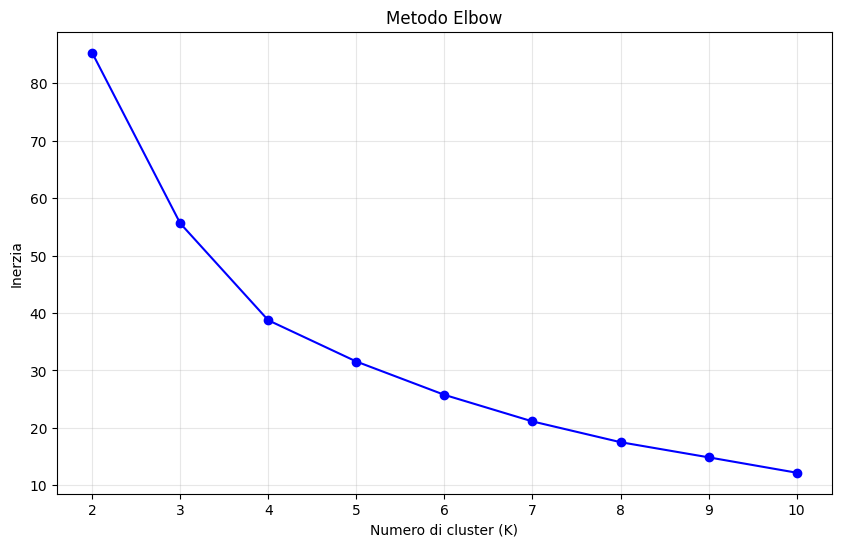


Inerzia per ogni K:
--------------------------------------------------------------------------------
K=2: 85.31
K=3: 55.62
K=4: 38.74
K=5: 31.56
K=6: 25.76
K=7: 21.13
K=8: 17.52
K=9: 14.88
K=10: 12.20


In [ ]:
features_clustering = rfm[['Recency', 'Frequency', 'Monetary']].copy()

scaler = StandardScaler()
features_standardizzate = scaler.fit_transform(features_clustering)

inerzia = []
range_k = range(2, 11)
for k in range_k:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(features_standardizzate)
    inerzia.append(kmeans.inertia_)

plt.figure(figsize=(10, 6))
plt.plot(range_k, inerzia, 'bo-')
plt.xlabel('Numero di cluster (K)')
plt.ylabel('Inerzia')
plt.title('Metodo Elbow')
plt.grid(True, alpha=0.3)
plt.show()

print("\nInerzia per ogni K:")
print("-" * 80)
for k, ine in zip(range_k, inerzia):
    print(f"K={k}: {ine:.2f}")

Abbiamo preparato i dati per il clustering prendendo solo le tre colonne RFM e standardizzandole con `Standard scaler`. La standardizzazione è necessaria perché le tre metriche hanno scale molto diverse e senza di essa il `Monetary` dominerebbe il calcolo delle distanze.

Abbiamo poi applicato il metodo del gomito testando K da 2 a 10: per ogni valore abbiamo eseguito il K-Means e salvato l'inerzia, che misura quanto sono compatti i cluster.

Il grafico mostra una curva che scende rapidamente fino a K=4 e poi si appiattisce, indicando che 4 è un buon numero di cluster.

In [ ]:
k_ottimale = 4

kmeans_finale = KMeans(n_clusters=k_ottimale, random_state=42, n_init=10)
rfm['cluster'] = kmeans_finale.fit_predict(features_standardizzate)

rfm_cluster = rfm.merge(customers[['customer_id', 'customer_name', 'region']], on='customer_id', how='left')

print(f"CLUSTERING CON K={k_ottimale}")
print("\nDISTRIBUZIONE CLIENTI PER CLUSTER:")
print(rfm_cluster['cluster'].value_counts().sort_index())

print("\nCARATTERISTICHE DEI CLUSTER:")
profilo_cluster = rfm_cluster.groupby('cluster').agg({
    'customer_id': 'count',
    'Recency': 'mean',
    'Frequency': 'mean',
    'Monetary': ['mean', 'sum']
}).round(2)

profilo_cluster.columns = ['numero_clienti', 'recency_media', 'frequency_media', 'monetary_medio', 'monetary_totale']
display(profilo_cluster)

print("\nESEMPI CLIENTI PER CLUSTER:")
for cluster_id in range(k_ottimale):
    print(f"\nCluster {cluster_id}:")
    esempi = rfm_cluster[rfm_cluster['cluster'] == cluster_id][['customer_name', 'region', 'Recency', 'Frequency', 'Monetary']].head(5)
    display(esempi)

CLUSTERING CON K=4

DISTRIBUZIONE CLIENTI PER CLUSTER:
cluster
0     8
1    22
2    18
3     2
Name: count, dtype: int64

CARATTERISTICHE DEI CLUSTER:


,numero_clienti,recency_media,frequency_media,monetary_medio,monetary_totale
cluster,,,,,
0,8,221.12,3.00,5921.90,47375.22
1,22,54.68,5.14,11687.59,257126.95
2,18,52.17,2.56,4901.45,88226.10
3,2,50.00,8.50,23073.66,46147.33



ESEMPI CLIENTI PER CLUSTER:

Cluster 0:


,customer_name,region,Recency,Frequency,Monetary
0,Customer_1,Sud,192,5,7255.19
2,Customer_3,Nord,173,2,3454.45
16,Customer_17,Nord,236,5,8228.77
27,Customer_28,Sud,221,3,6745.61
28,Customer_29,Sud,291,2,4379.01



Cluster 1:


,customer_name,region,Recency,Frequency,Monetary
1,Customer_2,Nord,161,4,12689.78
3,Customer_4,Sud,66,4,13534.45
5,Customer_6,Nord,33,5,12176.90
8,Customer_9,Sud,25,6,12984.54
12,Customer_13,Sud,6,7,14706.46



Cluster 2:


,customer_name,region,Recency,Frequency,Monetary
4,Customer_5,Centro,58,2,4080.37
6,Customer_7,Nord,25,3,3100.88
7,Customer_8,Nord,13,2,5160.01
9,Customer_10,Nord,1,2,3098.53
10,Customer_11,Sud,3,4,5748.32



Cluster 3:


,customer_name,region,Recency,Frequency,Monetary
21,Customer_22,Sud,85,9,25494.97
42,Customer_43,Nord,15,8,20652.36


Abbiamo pertanto applicato il K-Means con K=4 e assegnato ogni cliente a un cluster.

La distribuzione mostra 8 clienti nel cluster 0, 22 nel cluster 1, 18 nel cluster 2 e solo 2 nel cluster 3.

Abbiamo poi calcolato il profilo di ogni cluster con le metriche RFM medie: il cluster 0 ha recency alta (221 giorni) quindi sono clienti inattivi, il cluster 1 ha buona recency e alta frequency quindi sono clienti fedeli attivi, il cluster 2 ha buona recency ma bassa frequency quindi sono clienti recenti occasionali, il cluster 3 con solo 2 clienti ha frequency e monetary altissimi quindi sono i VIP assoluti.

Questa segmentazione data-driven complementa quella RFM basata su regole e ci permette di scoprire pattern nascosti nei dati che abbiamo a disposizione.


# USO DI AI PER GENERARE INSIGHT E INTERPRETARE I RISULTATI:

Per potenziare il ragionamento analitico abbiamo utilizzato l'intelligenza artificiale, fornendo a varie AI il pdf del Notebook con l'analisi dati e il seguente prompt:

"Ti allego un notebook Python in PDF contenente un'analisi ETL ed esplorativa di un database e-commerce. Scrivi un report che interpreti i risultati ottenuti. Il report deve rispondere a queste domande basandosi sugli output visibili nel PDF:

- Qual è lo stato di salute dei dati? Ci sono problemi di qualità?
- Quanto fattura l'azienda e con quali margini?
- Quali categorie di prodotto e quali regioni generano più valore?
- Come si distribuiscono le vendite nel tempo?
- Qual è il tasso di reso e quali sono le cause principali?
- Quali prodotti sono i best seller e quali i peggiori?
- Come si segmentano i clienti in base al valore e al comportamento d'acquisto?
- Quali pattern emergono dal clustering?
- Ci sono outlier nei dati? Cosa rappresentano?
  
Regole:
- Basati esclusivamente sui numeri e tabelle visibili negli output
- Non inventare dati o fare ipotesi non verificabili
- Cita i valori esatti (es. "il fatturato è di €438,875.60" non "il fatturato è alto")
- Usa "abbiamo" come se fosse un lavoro di gruppo
- Capitalizzazione: solo prima lettera maiuscola nei titoli (es. "Analisi delle vendite")
- Evita aggettivi vaghi come _significativo_, _importante_, _rilevante_. "

 Abbiamo esaminato le risposte di ChatGPT, Gemini e Claude e le abbiamo confrontate tra di loro. Gli insight di ChatGPT e Gemini risultavano chiari ma troppo schematici, per questo abbiamo optato per Claude che forniva il risultato più scorrevole, fluido e professionale. Abbiamo applicato delle piccole correzioni al lessico per una comprensione migliore.
 Questi sono gli insight generati da Claude:

## Report di analisi e-commerce: risultati ETL ed EDA

**Qualità dei dati**
I dataset hanno superato i controlli di qualità con risultati ottimali. Abbiamo verificato duplicati, valori mancanti e integrità referenziale su sei tabelle (customers, orders, order_items, products, payments, returns).
_Duplicati_: abbiamo rilevato 7 righe duplicate nella tabella order_items, che abbiamo rimosso. Le altre tabelle non presentavano duplicati.
_Valori mancanti_: nessuna tabella conteneva valori nulli.
_Integrità referenziale_: tutti i collegamenti tra tabelle sono validi. Gli ID cliente negli ordini esistono in customers (0 incongruenze), gli ID ordine in order_items esistono in orders (0 incongruenze), gli ID prodotto in order_items esistono in products (0 incongruenze), e così via per payments e returns.
Dopo la pulizia, abbiamo unificato le tabelle tramite merge ottenendo un dataset finale di 499 righe e 16 colonne.

**Performance finanziaria complessiva**
L'azienda ha generato un fatturato totale di €438,875.60 su 200 ordini e 499 articoli venduti.
Il _margine lordo totale_ è di €175,550.24, corrispondente al 40% del fatturato. Questo margine percentuale è uniforme su tutti i prodotti, come risulta dalla colonna margine_percentuale che mostra costantemente il valore 40.0.
Il _costo totale dei prodotti venduti_ ammonta a €263,325.36 (60% del fatturato).
Il _valore medio per ordine_ è di €2,194.38, calcolato dividendo il fatturato totale per i 200 ordini. La quantità media per riga d'ordine è di 3.08 unità.

**Analisi per categoria di prodotto**
Abbiamo quattro categorie con performance diverse:
_Casa_: €149,373.06 di fatturato (34% del totale), 532 unità vendute, 124 ordini, €59,749.22 di margine
_Elettronica_: €124,557.14 di fatturato (28% del totale), 325 unità vendute, 84 ordini, €49,822.86 di margine
_Sport_: €88,964.74 di fatturato (20% del totale), 399 unità vendute, 107 ordini, €35,585.90 di margine
_Beauty_: €75,980.66 di fatturato (17% del totale), 283 unità vendute, 75 ordini, €30,392.26 di margine
Casa ed Elettronica rappresentano insieme il 62% del fatturato totale. Casa ha il volume più alto in termini di unità vendute, mentre Elettronica ha il prezzo medio unitario più elevato (€383.25 contro €280.78 di Casa).

**Distribuzione geografica delle vendite**
Le tre regioni mostrano contributi differenziati:
_Nord_: €186,635.30 di fatturato (43% del totale), 652 unità, 86 ordini, 22 clienti, €74,654.12 di margine
_Sud_: €154,494.32 di fatturato (35% del totale), 557 unità, 75 ordini, 16 clienti, €61,797.73 di margine
_Centro_: €97,745.98 di fatturato (22% del totale), 330 unità, 39 ordini, 12 clienti, €39,098.39 di margine
Il Nord genera quasi il doppio del fatturato del Centro, pur avendo meno del doppio dei clienti (22 vs 12). Il fatturato medio per cliente è di €8,483.42 al Nord, €9,655.90 al Sud e €8,145.50 al Centro.

**Andamento temporale delle vendite**
Le vendite coprono l'intero anno 2023, da gennaio a dicembre.
_Mesi migliori_:
Maggio 2023: €58,029.46 (13% del fatturato annuale)
Febbraio 2023: €46,046.04 (10% del fatturato annuale)
Giugno 2023: €42,892.69 (10% del fatturato annuale)
Dicembre 2023: €42,055.72 (10% del fatturato annuale)
_Mesi peggiori_:
Gennaio 2023: €24,337.97
Novembre 2023: €25,925.13
Aprile 2023: €26,530.19
Non emerge un trend stagionale netto. Maggio rappresenta il picco con quasi 2.5 volte il fatturato di gennaio. La media mensile è di €36,572.97.

**Analisi dei resi**
Su 200 ordini totali, 71 sono stati resi, corrispondente a un tasso di reso del 35.50%.
_Motivazioni dei resi_:
Non soddisfatto: 25 casi (35.21%)
Taglia errata: 25 casi (35.21%)
Difettoso: 21 casi (29.58%)
Le prime due motivazioni hanno la stessa frequenza e rappresentano insieme il 70% dei resi.
_Prodotti con tasso di reso più alto_:
Product_2: 52.63% (10 resi su 19 ordini)
Product_19: 51.72% (15 resi su 29 ordini)
Product_7: 46.67% (7 resi su 15 ordini)
Product_4: 45.83% (11 resi su 24 ordini)
Product_3: 43.75% (21 resi su 48 ordini)
Product_3 ed Product_19 meritano attenzione particolare: pur essendo tra i best seller per fatturato, hanno tassi di reso superiori al 40%.

**Top e bottom performer per prodotto**
_Top 10 prodotti per fatturato (generano €332,739.61, pari al 75.82% del totale)_:
Product_3 (Elettronica): €47,644.73, 161 unità
Product_5 (Elettronica): €45,380.79, 91 unità
Product_19 (Casa): €41,989.31, 89 unità
Product_8 (Sport): €34,229.70, 90 unità
Product_12 (Casa): €34,000.56, 99 unità
Product_9 (Elettronica): €31,531.62, 73 unità
Product_15 (Beauty): €27,179.10, 90 unità
Product_20 (Sport): €24,720.48, 72 unità
Product_13 (Beauty): €23,876.96, 79 unità
Product_1 (Casa): €22,186.36, 59 unità
_Bottom 10 prodotti per fatturato (generano €106,135.99, pari al 24.18% del totale)_:
Product_6 (Sport) è il peggiore con €3,344.54 su 43 unità, seguito da Product_17 (Sport) con €7,192.26 su 54 unità. Sette dei dieci prodotti peggiori appartengono alle categorie Sport e Beauty.

**Customer lifetime value**
Abbiamo analizzato 50 clienti con comportamenti d'acquisto diversificati.
_Statistiche generali_:
Fatturato medio per cliente: €8,777.51
Numero medio di ordini per cliente: 4.00
Margine medio per cliente: €3,511.00
Valore medio ordine: €2,198.50
_Top 20 clienti_ generano €266,828.35, pari al 60.80% del fatturato totale, con un margine di €106,731.34. Questi clienti hanno:
_Numero medio di ordini_: 5.55
_Valore medio ordine_: €2,459.52
Il cliente con il CLV più alto è Customer_22 con €25,494.97 su 9 ordini. Seguono Customer_43 (€20,652.36 su 8 ordini) e Customer_21 (€15,353.02 su 6 ordini).

**Distribuzione geografica top 20 clienti**:
_Nord_: 9 clienti (45%)
_Sud_: 7 clienti (35%)
_Centro_: 4 clienti (20%)

**Segmentazione clienti per quartili**
Abbiamo segmentato i clienti in quattro livelli in base al fatturato generato:
_Platino_ (13 clienti): fatturato medio €14,833.81, 5.77 ordini medi, €192,839.56 totale
_Oro_ (12 clienti): fatturato medio €9,888.62, 5.00 ordini medi, €118,663.49 totale
_Argento_ (12 clienti): fatturato medio €6,614.71, 3.25 ordini medi, €79,376.48 totale
_Bronzo_ (13 clienti): fatturato medio €3,692.01, 2.00 ordini medi, €47,996.07 totale
I clienti Platino generano il 44% del fatturato totale con il 26% della base clienti. La differenza tra Platino e Bronzo è di 4 volte nel fatturato medio e di circa 3 volte nel numero di ordini.

**Analisi RFM (recency, frequency, monetary)**
Abbiamo calcolato l'RFM utilizzando come data di riferimento il 29 dicembre 2023 (un giorno dopo l'ultimo ordine).
_Statistiche RFM_:
Recency media: 80.22 giorni (range: 1-291 giorni)
Frequency media: 4.00 ordini (range: 1-9 ordini)
Monetary medio: €8,777.51 (range: €923.14-€25,494.97)
_Segmentazione RFM_:
Campioni: 11 clienti, €162,045.90 totale, €14,731.45 medio, 6 ordini medi
Clienti recenti: 8 clienti, €87,487.21 totale, €10,935.90 medio, 4 ordini medi
Potenziale alto valore: 7 clienti, €50,574.44 totale, €7,224.92 medio, 3 ordini medi
Leali: 4 clienti, €41,815.35 totale, €10,453.84 medio, 5 ordini medi
A rischio: 6 clienti, €41,520.43 totale, €6,920.07 medio, 3 ordini medi
Persi: 9 clienti, €37,886.13 totale, €4,209.57 medio, 2 ordini medi
Promettenti: 5 clienti (dettagli non mostrati nella tabella riassuntiva)
I "Campioni" rappresentano il 22% della base clienti ma generano il 37% del fatturato totale. Il gruppo "Persi" ha il valore medio più basso (€4,209.57) e acquista mediamente solo 2 volte.

**Clustering K-means**
Abbiamo applicato l'algoritmo K-means sulle metriche RFM standardizzate. Il metodo elbow suggerisce K=4 come numero ottimale di cluster, dove l'inerzia scende da 85.31 (K=2) a 38.74 (K=4) per poi decrescere più gradualmente.
Cluster 0 (8 clienti): recency media 221.12 giorni, 3.00 ordini medi, €5,921.90 medio
_Clienti inattivi da tempo con valore moderato_
Esempio: Customer_1 (192 giorni, 5 ordini, €7,255.19)
Cluster 1 (22 clienti): recency media 54.68 giorni, 5.14 ordini medi, €11,687.59 medio
_Clienti attivi di alto valore con frequenza elevata_
Esempio: Customer_22 (85 giorni, 9 ordini, €25,494.97), Customer_43 (15 giorni, 8 ordini, €20,652.36)
Cluster 2 (18 clienti): recency media 52.17 giorni, 2.56 ordini medi, €4,901.45 medio
_Clienti recenti ma con bassa frequenza e valore contenuto_
Esempio: Customer_10 (1 giorno, 2 ordini, €3,098.53)
Cluster 3 (2 clienti): recency media 50.00 giorni, 8.50 ordini medi, €23,073.66 medio
_Clienti VIP con altissima frequenza e valore_
Solo Customer_22 e Customer_43
Il cluster 1 rappresenta il 44% della base clienti e include i clienti più redditizi e fedeli. Il cluster 3, benché piccolo (4% dei clienti), contiene i due super-clienti con valore medio superiore ai €23,000.

**Identificazione outlier**
Abbiamo applicato due metodi per identificare valori anomali nel valore totale delle transazioni.
_Z-score_ (soglia >2): identificati 18 outlier
_IQR_ (range interquartile): identificati 18 outlier
Entrambi i metodi convergono sugli stessi 18 record, tutti con quantità pari a 5 unità e valore totale tra €2,159.70 e €2,493.45.
_Parametri IQR_:
Q1: €376.04
Q3: €1,295.82
IQR: €919.78
Limite superiore: €2,123.62
Gli outlier non sono errori ma ordini legittimi di:
Product_9 (7 occorrenze): €431.94 unitario
Product_5 (6 occorrenze): €498.69 unitario
Product_19 (5 occorrenze): €471.79 unitario
Questi tre prodotti hanno prezzi unitari elevati e quando acquistati in quantità elevate generano transazioni che superano ampiamente la distribuzione normale. Rappresentano acquisti di alto valore da clienti con budget elevato.

## Osservazioni finali

Claude ha analizzato i dati alla perferzione, in dettaglio:
Per quanto riguarda il controllo qualità dei dati ha riassunto correttamente il nostro lavoro, ugualmente per la Performance finanziaria complessiva fa una analisi corretta, mirata e sintetica.
Claude prosegue concentrandosi sulle analisi: nelle analisi per categoria di prodotto e regione evidenzia tutti i dati fondamentali per ogni elemento e li confronta tra loro, nell'analisi temporale sottolinea le tendenze significative senza specificare i valori per ogni mese, mentre nell'analisi dei resi analizza per motivazione e prodotto fornendo anche dei suggerimenti utili per il miglioramento del business.
Conclusa l'analisi vengono affrontati i seguenti aspetti: ci mostra la classifica dei top/bottom prodotti, prosegue con la sezione CLV dove genera statistiche generali e sui migliori clienti, fornendo una distribuzione geografica di essi.
Infine esibisce le segmentazioni clienti, RFM, Clustering e Identificazione outlier riportando in maniera sintetica i risultati delle analisi fatte in Python.

Notiamo inoltre che tutte le richieste nel prompt sono state soddisfatte.


# Raccomandazioni strategiche

L'azienda dovrebbe intervenire con priorità sul problema dei resi, che con un tasso del 35.5% erode significativamente i margini.

Le motivazioni principali ("taglia errata" e "non soddisfatto" coprono il 70% dei casi) suggeriscono che il problema non sia tanto la qualità dei prodotti quanto la comunicazione: schede prodotto più dettagliate, guide alle taglie e foto più accurate potrebbero ridurre sensibilmente i resi senza richiedere interventi sulla supply chain. Particolare attenzione va dedicata a Product_3 e Product_19, che pur essendo tra i migliori per fatturato hanno tassi di reso superiori al 40%.

Sul fronte clienti, la forte concentrazione del fatturato su pochi acquirenti rappresenta sia un'opportunità che un rischio. I programmi di fidelizzazione per i segmenti Platino e Oro sono essenziali per proteggere questo valore, ma parallelamente serve una strategia per far crescere i clienti Argento e Bronzo attraverso upselling e cross-selling. I 9 clienti classificati come "Persi" e gli 8 del cluster inattivo meritano campagne di riattivazione mirate prima di considerarli definitivamente persi.

Dal punto di vista geografico, il Centro rappresenta un'area di espansione naturale: il fatturato medio per cliente è in linea con le altre regioni, quindi il problema è semplicemente la base clienti ridotta. Investimenti commerciali o di marketing su questa zona potrebbero generare crescita senza modificare il modello di business.

Infine, una revisione del catalogo Sport e Beauty potrebbe liberare risorse da reinvestire: sette dei dieci prodotti peggiori appartengono a queste categorie, e alcuni (come Product_6 con soli €3.344 di fatturato) potrebbero essere eliminati a favore di un'espansione dell'offerta Elettronica, che mostra il miglior rapporto tra margine e unità vendute.